In [1]:

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os


In [2]:
import os
from os import listdir
import glob

In [3]:
data_dir="final/"

In [4]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [5]:
train_samples =get_files(data_dir)
num_classes=len(glob.glob(data_dir+"/*"))
print(num_classes,"Classes")
print(train_samples,"Train images")


2 Classes
2097 Train images


In [6]:
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [7]:
img_width,img_height =299,299
input_shape=(img_width,img_height,3)
batch_size =32
train_generator =datagen.flow_from_directory(data_dir,
                                            target_size=(img_width,img_height),
                                            batch_size=batch_size,
                                            subset='training')
validation_generator =datagen.flow_from_directory(data_dir,
                                            target_size=(img_width,img_height),
                                            batch_size=batch_size,
                                            subset='validation')

Found 1678 images belonging to 2 classes.
Found 419 images belonging to 2 classes.


In [8]:

baseModel = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(299, 299, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(8, 8))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [9]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

INIT_LR = 1e-4
EPOCHS = 10

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# train the network
print("[INFO] training network...")

# distribution
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])



train=model.fit(train_generator,
                epochs=EPOCHS,
                validation_data= validation_generator ,
                verbose=1)

[INFO] training network...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 53 steps, validate for 14 steps
Epoch 1/10
53/53 [==============================] - 30s 559ms/step - loss: 0.3224 - accuracy: 0.8677 - val_loss: 0.2239 - val_accuracy: 0.8902
Epoch 2/10
53/53 [==============================] - 15s 276ms/step - loss: 0.1401 - accuracy: 0.9583 - val_loss: 0.1174 - val_accuracy: 0.9761
Epoch 3/10
53/53 [==============================] - 15s 278ms/step - loss: 0.0873 - accuracy: 0.9756 - val_loss: 0.0754 - val_accuracy: 1.0000
Epoch 4/10
53/53 [==============================] - 15s 277ms/step - loss: 0.0516 - accuracy: 0.9881 - val_loss: 0.0636 - val_accuracy: 1.0000
Epoch 5/10
53/53 [==============================] - 15s 277ms/step - loss: 0.0395 - accuracy: 0.9940 - val_loss: 0.0420 - val_accuracy: 1.0000
Epoch 6/10
53/53 [==============================] - 15s 277ms/step - loss: 0.0345 - accuracy: 0.9923 - val_loss: 0.0328 - val_accuracy: 1.0000
Epoch 7/10
53/53 [=====

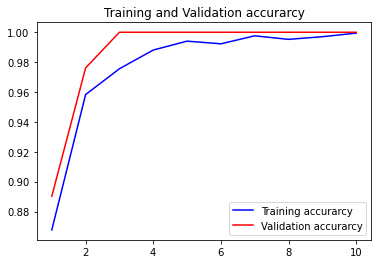

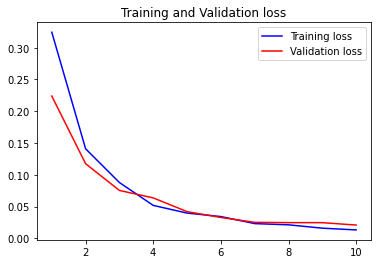

In [11]:
acc = train.history['accuracy']
val_acc = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [56]:
testing_train_generator =datagen.flow_from_directory("final/",
                                            target_size=(img_width,img_height),
                                            shuffle = False,
                                            batch_size=batch_size)

Found 2097 images belonging to 2 classes.


In [57]:
testing_train_generator.reset()
predictions = model.predict_generator(testing_train_generator, steps=len(testing_train_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=testing_train_generator.classes, y_pred=y, target_names=testing_train_generator.class_indices)
print(cr)

Classification Report
              precision    recall  f1-score   support

       NOTOK       1.00      0.75      0.86       340
          OK       0.95      1.00      0.98      1757

    accuracy                           0.96      2097
   macro avg       0.98      0.88      0.92      2097
weighted avg       0.96      0.96      0.96      2097



In [49]:
test_generator =datagen.flow_from_directory("test/",
                                            target_size=(img_width,img_height),
                                            shuffle = False,
                                            batch_size=batch_size)

Found 105 images belonging to 2 classes.


In [50]:
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

Classification Report
              precision    recall  f1-score   support

       NOTOK       1.00      0.76      0.87        17
          OK       0.96      1.00      0.98        88

    accuracy                           0.96       105
   macro avg       0.98      0.88      0.92       105
weighted avg       0.96      0.96      0.96       105



In [52]:
test_generator =datagen.flow_from_directory("test/",
                                            target_size=(img_width,img_height),
                                            shuffle = False,
                                            batch_size=1)

Found 105 images belonging to 2 classes.


In [53]:
count=0
for i in range (0,len(test_generator.filenames)):
    rand = i

    predict = model.predict_generator(test_generator[rand],steps = 1)
    #print(predict)
    y = np.argmax(predict, axis=1)
    #print(y,np.argmax(test_generator[rand][1], axis=1))
    if( y != np.argmax(test_generator[rand][1], axis=1) ):
        #print("Ye galat hai")
        #print(y,np.argmax(test_generator[rand][1], axis=1) , rand)
        count += 1
        
    #print( np.argmax(test_generator[random][1], axis=1))
print(count)

4


In [45]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        "test/",
        target_size=(299, 299),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

Found 105 images belonging to 2 classes.


In [46]:
len(test_generator.filenames)

105

In [47]:
count=0
for i in range (0,len(test_generator.filenames)):
    rand = i

    predict = model.predict_generator(test_generator[rand],steps = 1)
    #print(predict)
    y = np.argmax(predict, axis=1)
    #print(y,np.argmax(test_generator[rand][1], axis=1))
    if( y != np.argmax(test_generator[rand][1], axis=1) ):
        #print("Ye galat hai")
        #print(y,np.argmax(test_generator[rand][1], axis=1) , rand)
        count += 1
        
    #print( np.argmax(test_generator[random][1], axis=1))
print(count)

4


In [48]:
count=0
for i in range (0,len(test_generator.filenames)):
    rand = i

    predict = model.predict_generator(test_generator[rand],steps = 1)
    #print(predict)
    y = np.argmax(predict, axis=1)
    #print(y,np.argmax(test_generator[rand][1], axis=1))
    if( y != np.argmax(test_generator[rand][1], axis=1) ):
        #print("Ye galat hai")
        print(y,np.argmax(test_generator[rand][1], axis=1) , rand)
        count += 1
        
        
    #print( np.argmax(test_generator[random][1], axis=1))
print(count)

[1] [0] 7
[1] [0] 10
[1] [0] 12
[1] [0] 15
4


In [37]:
count=0
for i in range (0,len(test_generator.filenames)):
    rand = i

    predict = model.predict_generator(test_generator[rand],steps = 1)
    #print(predict)
    y = np.argmax(predict, axis=1)
    #print(y,np.argmax(test_generator[rand][1], axis=1))
    if( y != np.argmax(test_generator[rand][1], axis=1) ):
        #print("Ye galat hai")
        print(y,np.argmax(test_generator[rand][1], axis=1) , rand)
        count += 1
        
    #print( np.argmax(test_generator[random][1], axis=1))
print(count)

[1] [0] 7
[1] [0] 10
[1] [0] 12
[1] [0] 15
4


In [54]:


test2_generator = test_datagen.flow_from_directory(
        "final/",
        target_size=(299, 299),
        shuffle = False,
        batch_size=1)

filenames = test2_generator.filenames
nb_samples = len(filenames)

Found 2097 images belonging to 2 classes.


In [55]:
len(test2_generator.filenames)
count=0
for i in range (0,len(test2_generator.filenames)):
    rand = i

    predict = model.predict_generator(test2_generator[rand],steps = 1)
    #print(predict)
    y = np.argmax(predict, axis=1)
    #print(y,np.argmax(test_generator[rand][1], axis=1))
    if( y != np.argmax(test2_generator[rand][1], axis=1) ):
        #print("Ye galat hai")
        print(y,np.argmax(test2_generator[rand][1], axis=1) , rand)
        count += 1
        
    #print( np.argmax(test_generator[random][1], axis=1))
print(count)

[1] [0] 101
[1] [0] 107
[1] [0] 140
[1] [0] 141
[1] [0] 142
[1] [0] 143
[1] [0] 144
[1] [0] 145
[1] [0] 146
[1] [0] 147
[1] [0] 148
[1] [0] 149
[1] [0] 150
[1] [0] 151
[1] [0] 152
[1] [0] 153
[1] [0] 154
[1] [0] 155
[1] [0] 156
[1] [0] 157
[1] [0] 158
[1] [0] 159
[1] [0] 167
[1] [0] 200
[1] [0] 201
[1] [0] 202
[1] [0] 203
[1] [0] 204
[1] [0] 205
[1] [0] 206
[1] [0] 207
[1] [0] 208
[1] [0] 209
[1] [0] 210
[1] [0] 211
[1] [0] 212
[1] [0] 213
[1] [0] 214
[1] [0] 215
[1] [0] 216
[1] [0] 217
[1] [0] 218
[1] [0] 219
[1] [0] 240
[1] [0] 241
[1] [0] 242
[1] [0] 243
[1] [0] 244
[1] [0] 245
[1] [0] 246
[1] [0] 247
[1] [0] 248
[1] [0] 249
[1] [0] 250
[1] [0] 251
[1] [0] 252
[1] [0] 253
[1] [0] 254
[1] [0] 255
[1] [0] 256
[1] [0] 257
[1] [0] 258
[1] [0] 259
[1] [0] 260
[1] [0] 261
[1] [0] 263
[1] [0] 265
[1] [0] 267
[1] [0] 269
[1] [0] 271
[1] [0] 273
[1] [0] 274
[1] [0] 275
[1] [0] 277
[1] [0] 300
[1] [0] 301
[1] [0] 302
[1] [0] 305
[1] [0] 307
[1] [0] 308
[1] [0] 310
[1] [0] 314
[1] [0] 316
[1] 

In [39]:
len(test2_generator.filenames)
count=0
for i in range (0,len(test2_generator.filenames)):
    rand = i

    predict = model.predict_generator(test2_generator[rand],steps = 1)
    #print(predict)
    y = np.argmax(predict, axis=1)
    #print(y,np.argmax(test_generator[rand][1], axis=1))
    if( y != np.argmax(test2_generator[rand][1], axis=1) ):
        #print("Ye galat hai")
        print(y,np.argmax(test2_generator[rand][1], axis=1) , rand)
        count += 1
        
    #print( np.argmax(test_generator[random][1], axis=1))
print(count)

[1] [0] 3
[1] [0] 9
[1] [0] 26
[1] [0] 42
[1] [0] 58
[1] [0] 70
[1] [0] 87
[1] [0] 121
[1] [0] 133
[1] [0] 139
[1] [0] 153
[1] [0] 168
[1] [0] 170
[1] [0] 231
[1] [0] 243
[1] [0] 265
[1] [0] 274
[1] [0] 278
[1] [0] 302
[1] [0] 325
[1] [0] 367
[1] [0] 372
[1] [0] 469
[1] [0] 499
[1] [0] 533
[1] [0] 557
[1] [0] 561
[1] [0] 573
[1] [0] 606
[1] [0] 674
[1] [0] 694
[1] [0] 717
[1] [0] 756
[1] [0] 790
[1] [0] 814
[1] [0] 822
[1] [0] 823
[1] [0] 825
[1] [0] 1012
[1] [0] 1026
[1] [0] 1029
[1] [0] 1044
[1] [0] 1054
[1] [0] 1070
[1] [0] 1088
[1] [0] 1099
[1] [0] 1105
[1] [0] 1155
[1] [0] 1159
[1] [0] 1174
[1] [0] 1188
[1] [0] 1200
[1] [0] 1208
[1] [0] 1214
[1] [0] 1330
[1] [0] 1346
[1] [0] 1375
[1] [0] 1382
[1] [0] 1387
[1] [0] 1402
[1] [0] 1420
[1] [0] 1504
[1] [0] 1509
[1] [0] 1517
[1] [0] 1525
[1] [0] 1551
[1] [0] 1598
[1] [0] 1663
[1] [0] 1701
[1] [0] 1707
[1] [0] 1712
[1] [0] 1824
[1] [0] 1836
[1] [0] 1838
[1] [0] 1862
[1] [0] 1935
[1] [0] 1947
[1] [0] 1965
[1] [0] 1967
[1] [0] 1977
[1] [0]